In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls_pytorch import *
from utils import *
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
from torch import logsumexp
import sys
import time
import datetime

In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 20
NUM_HIDDEN = 32
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS_GLOBAL = D
NUM_OBS_LOCAL = D + K*D + K*D
BATCH_SIZE = 50
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
CUDA = False
PATH = 'oneshot-rws'

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset/sequences.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset/init.npy')).float()
num_seqs = Xs.shape[0]

In [4]:
class Encoder_init(nn.Module):
    def __init__(self, num_obs=NUM_OBS_GLOBAL,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_stats))

        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.mus_mean = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.prior_mean = torch.zeros(K*D)
        self.prior_nu = torch.ones(K*D) * 0.3
        self.prior_alpha = torch.ones(K*D) * 3.0
        self.prior_beta = torch.ones(K*D) * 3.0
        
    def forward(self, obs):
        stats = self.enc_stats(obs).sum(-2) ## B * N * D --> B * STATS_DIM 
        q_alpha = self.sigmas_log_alpha(stats).exp() ## B * K * D
        q_beta = self.sigmas_log_beta(stats).exp() ## B * K * D
        q_precisions = Gamma(q_alpha, q_beta)
        precisions = q_precisions.sample() ##Non-Reparam
        log_q_precisions = q_precisions.log_prob(precisions).sum(-1)
        log_p_precisions = Gamma(self.prior_alpha, self.prior_beta).log_prob(precisions).sum(-1)
        ##
        q_mean = self.mus_mean(stats)
        q_nu = self.mus_log_nu(stats).exp()
        q_sigma = 1. / (q_nu * precisions).sqrt() ## S * B * (K*D)
        q_means = Normal(q_mean, q_sigma)
        means = q_means.sample()  
        log_q_means = q_means.log_prob(means).sum(-1)
        log_p_means = Normal(self.prior_mean, 1. / (self.prior_nu * precisions).sqrt()).log_prob(means).sum(-1)
        return q_alpha, q_beta, q_mean, q_nu, means, precisions, log_q_means+log_q_precisions,  log_p_means+log_p_precisions## mus_mean and mus_sigma are S * B * K * D
    
class Encoder_local(nn.Module):
    def __init__(self, num_obs=NUM_OBS_LOCAL,
                       num_hidden=NUM_HIDDEN,
                       num_latents=K):
        super(self.__class__, self).__init__()
        self.enc_onehot = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents),
            nn.Softmax(-1))
        
        self.prior_pi = torch.ones(K) * (1./ K)
        
    def forward(self, obs, means, precisions):
        means_flat = means.unsqueeze(-2).repeat(1, 1, N, 1)
        precisions_flat = precisions.unsqueeze(-2).repeat(1, 1, N, 1)
        data = torch.cat((obs, means_flat, precisions_flat), -1)
        
        q_pi = self.enc_onehot(data)
        q_zs = cat(q_pi)
        zs = q_zs.sample()
        log_q_z = q_zs.log_prob(zs).sum(-1) ## S * B
        log_p_z = cat(self.prior_pi).log_prob(zs).sum(-1)
        return q_pi, zs, log_q_z, log_p_z

In [5]:
def initialize():
    enc_init = Encoder_init()
    enc_local = Encoder_local()

    optimizer =  torch.optim.Adam(list(enc_init.parameters()) + list(enc_local.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_init, enc_local, optimizer
enc_init, enc_local, optimizer = initialize()

In [6]:
def rws(enc_init, enc_local, x, K, D, num_samples, batch_size):
    q_alpha, q_beta, q_mean, q_nu, means, precisions, log_q_eta, log_p_eta = enc_init(batch_Xs) 
    q_pi, zs, log_q_z, log_p_z = enc_local(batch_Xs, means, precisions)

    mus_flat = means.view(num_samples, batch_size, K, D)
    precisions_flat = precisions.view(num_samples, batch_size, K, D)
    ll = loglikelihood(batch_Xs, zs, mus_flat, precisions_flat, D)
    log_weights = log_p_eta + log_p_z - log_q_eta - log_q_z + ll

    weights = torch.exp(log_weights - logsumexp(log_weights, dim=0)).detach()
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean()
    ess = (1. / (weights ** 2).sum(0)).mean()
    ## KL
    #### prior parameters
    p_alpha = enc_init.prior_alpha.view(K, D).unsqueeze(0).unsqueeze(0).repeat(num_samples, batch_size, 1, 1)
    p_beta = enc_init.prior_beta.view(K, D).unsqueeze(0).unsqueeze(0).repeat(num_samples, batch_size, 1, 1)
    p_mean = enc_init.prior_mean.view(K, D).unsqueeze(0).unsqueeze(0).repeat(num_samples, batch_size, 1, 1)
    p_nu = enc_init.prior_nu.view(K, D).unsqueeze(0).unsqueeze(0).repeat(num_samples, batch_size, 1, 1)
    p_pi = enc_local.prior_pi.unsqueeze(0).unsqueeze(0).unsqueeze(0).repeat(num_samples, batch_size, N, 1)
    #### variational parameters
    q_mean_f = q_mean.view(num_samples, batch_size, K, D)
    q_nu_f = q_nu.view(num_samples, batch_size, K, D)
    q_alpha_f = q_alpha.view(num_samples, batch_size, K, D)
    q_beta_f = q_beta.view(num_samples, batch_size, K, D)
    means_f = means.view(num_samples, batch_size, K, D)
    precisions_f = precisions.view(num_samples, batch_size, K, D)
    ####
    kl_eta_ex, kl_eta_in, kl_z_ex, kl_z_in = kls_step(x, zs, q_mean_f, q_nu_f, q_alpha_f, q_beta_f, q_pi, p_mean, p_nu, p_alpha, p_beta, p_pi, means_f, precisions_f, N, K, D, batch_size)
    ##
    KL_eta_ex = torch.mul(weights, kl_eta_ex).sum(0).mean()
    KL_eta_in = torch.mul(weights, kl_eta_in).sum(0).mean()
    KL_z_ex = torch.mul(weights, kl_z_ex).sum(0).mean()
    KL_z_in = torch.mul(weights, kl_z_in).sum(0).mean() 
    return eubo, elbo, ess, KL_eta_ex, KL_eta_in, KL_z_ex, KL_z_in

In [7]:
def shuffler(batch_Xs, N, K, D, batch_size):
    indices = torch.cat([torch.randperm(N).unsqueeze(0) for b in range(batch_size)])
    indices_Xs = indices.unsqueeze(-1).repeat(1, 1, D)
    return torch.gather(batch_Xs, 1, indices_Xs)

In [8]:
EUBOs = []
ELBOs = []
ESSs = []
flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO, ELBO, ESS, KLs_eta_ex, KLs_eta_in, KL_z_ex, KL_z_in\n')
flog.close()

num_batches = int((Xs.shape[0] / BATCH_SIZE))

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    indices = torch.randperm(num_seqs)
    
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_eta_ex_os = 0.0
    KL_eta_in_os = 0.0
    KL_z_ex_os = 0.0
    KL_z_in_os = 0.0
    
    
    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Xs = shuffler(batch_Xs, N, K, D, BATCH_SIZE).repeat(NUM_SAMPLES, 1, 1, 1)
        eubo, elbo, ess, KL_eta_ex, KL_eta_in, KL_z_ex, KL_z_in = rws(enc_init, enc_local, batch_Xs, K, D, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_eta_ex_os += KL_eta_ex.item()
        KL_eta_in_os += KL_eta_in.item()
        KL_z_ex_os += KL_z_ex.item()
        KL_z_in_os += KL_z_in.item()
        flog = open('results/log-' + PATH + '.txt', 'a+')
        flog.write(str(eubo.item()) + ', ' + str(elbo.item()) + ', ' + str(ess.item()) + ', ' + 
               str(KL_eta_ex.item()) + ', ' + str(KL_eta_in.item()) + ', ' + str(KL_z_ex.item()) + ', ' + str(KL_z_in.item()) + '\n')
                     
    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    KL_eta_ex_os /= num_batches
    KL_eta_in_os /= num_batches
    KL_z_ex_os /= num_batches
    KL_z_in_os /= num_batches 
    
    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS) 
    time_end = time.time()
    print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, EX_eta=%.3f, IN_eta=%.3f, EX_z=%.3f, IN_z=%.3f (%ds)'
            % (epoch, EUBO, ELBO, ESS,  KL_eta_ex_os, KL_eta_in_os, KL_z_ex_os, KL_z_in_os, time_end - time_start))


epoch=0, EUBO=-278.686, ELBO=-575.252, ESS=1.063, EX_eta=383.302, IN_eta=18.581, EX_z=100.063, IN_z=16.949 (12s)
epoch=1, EUBO=-201.806, ELBO=-296.826, ESS=1.149, EX_eta=122.443, IN_eta=16.765, EX_z=26.752, IN_z=10.321 (9s)
epoch=2, EUBO=-191.903, ELBO=-253.376, ESS=1.240, EX_eta=80.554, IN_eta=17.499, EX_z=20.001, IN_z=8.348 (12s)
epoch=3, EUBO=-186.820, ELBO=-231.149, ESS=1.348, EX_eta=60.438, IN_eta=18.643, EX_z=15.449, IN_z=6.628 (8s)
epoch=4, EUBO=-182.775, ELBO=-223.157, ESS=1.361, EX_eta=56.276, IN_eta=22.273, EX_z=13.178, IN_z=6.241 (11s)
epoch=5, EUBO=-179.479, ELBO=-218.797, ESS=1.375, EX_eta=55.475, IN_eta=25.078, EX_z=12.102, IN_z=5.778 (12s)
epoch=6, EUBO=-176.866, ELBO=-215.227, ESS=1.384, EX_eta=55.364, IN_eta=26.049, EX_z=10.168, IN_z=5.387 (12s)
epoch=7, EUBO=-173.892, ELBO=-209.278, ESS=1.385, EX_eta=53.730, IN_eta=28.021, EX_z=8.913, IN_z=5.103 (12s)
epoch=8, EUBO=-171.578, ELBO=-208.126, ESS=1.356, EX_eta=54.741, IN_eta=27.140, EX_z=8.447, IN_z=5.155 (12s)
epoch=9, 

In [9]:
# torch.save(enc_global.state_dict(), 'models/global-enc-' + PATH)
# torch.save(enc_local.state_dict(), 'models/local-enc' + PATH)

In [10]:
save_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, PATH, 'Epoch')

NameError: name 'save_results' is not defined

In [ ]:
plot_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, NUM_SAMPLES, num_batches, PATH)

In [14]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    batch_Xs = Xs[batch_indices]
    batch_Xs = shuffler(batch_Xs, N, K, D, batch_size)
    return batch_Xs.repeat(1, 1, 1, 1)

data = sample_single_batch(num_seqs, N, K, D, batch_size=50)
##
q_alpha, q_beta, q_mean, q_nu, means, precisions, log_q_eta, log_p_eta = enc_init(data) 
q_pi, zs, log_q_z, log_p_z = enc_local(data, means, precisions)

In [23]:
def plot_samples(data, q_alpha, q_beta, q_mean, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,50))
    Xs = data[0].cpu()
#     Zs = q_z['zs'].dist.probs[0].cpu()
    precisions_mean = q_alpha / q_beta
    covs_mean = (1. / precisions_mean[0].cpu().data.numpy())
    means_mean = q_mean[0].cpu().data.numpy()

    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = Xs[b].data.numpy()
#         z = Zs[b].data.numpy()
#         covs = np.zeros((K, D, D))
        mu = means_mean[b].reshape(K, D)
        cov = covs_mean[b].reshape(K, D)
#         assignments = z
        for k in range(K):
            cov_k = np.diag(cov[k])
#             xk = x[np.where(assignments == k)]
#             ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            ax.scatter(x[:, 0], x[:, 1])
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-10, 10])
        ax.set_xlim([-10, 10])
    plt.savefig('results/modes' + PATH + '.svg')

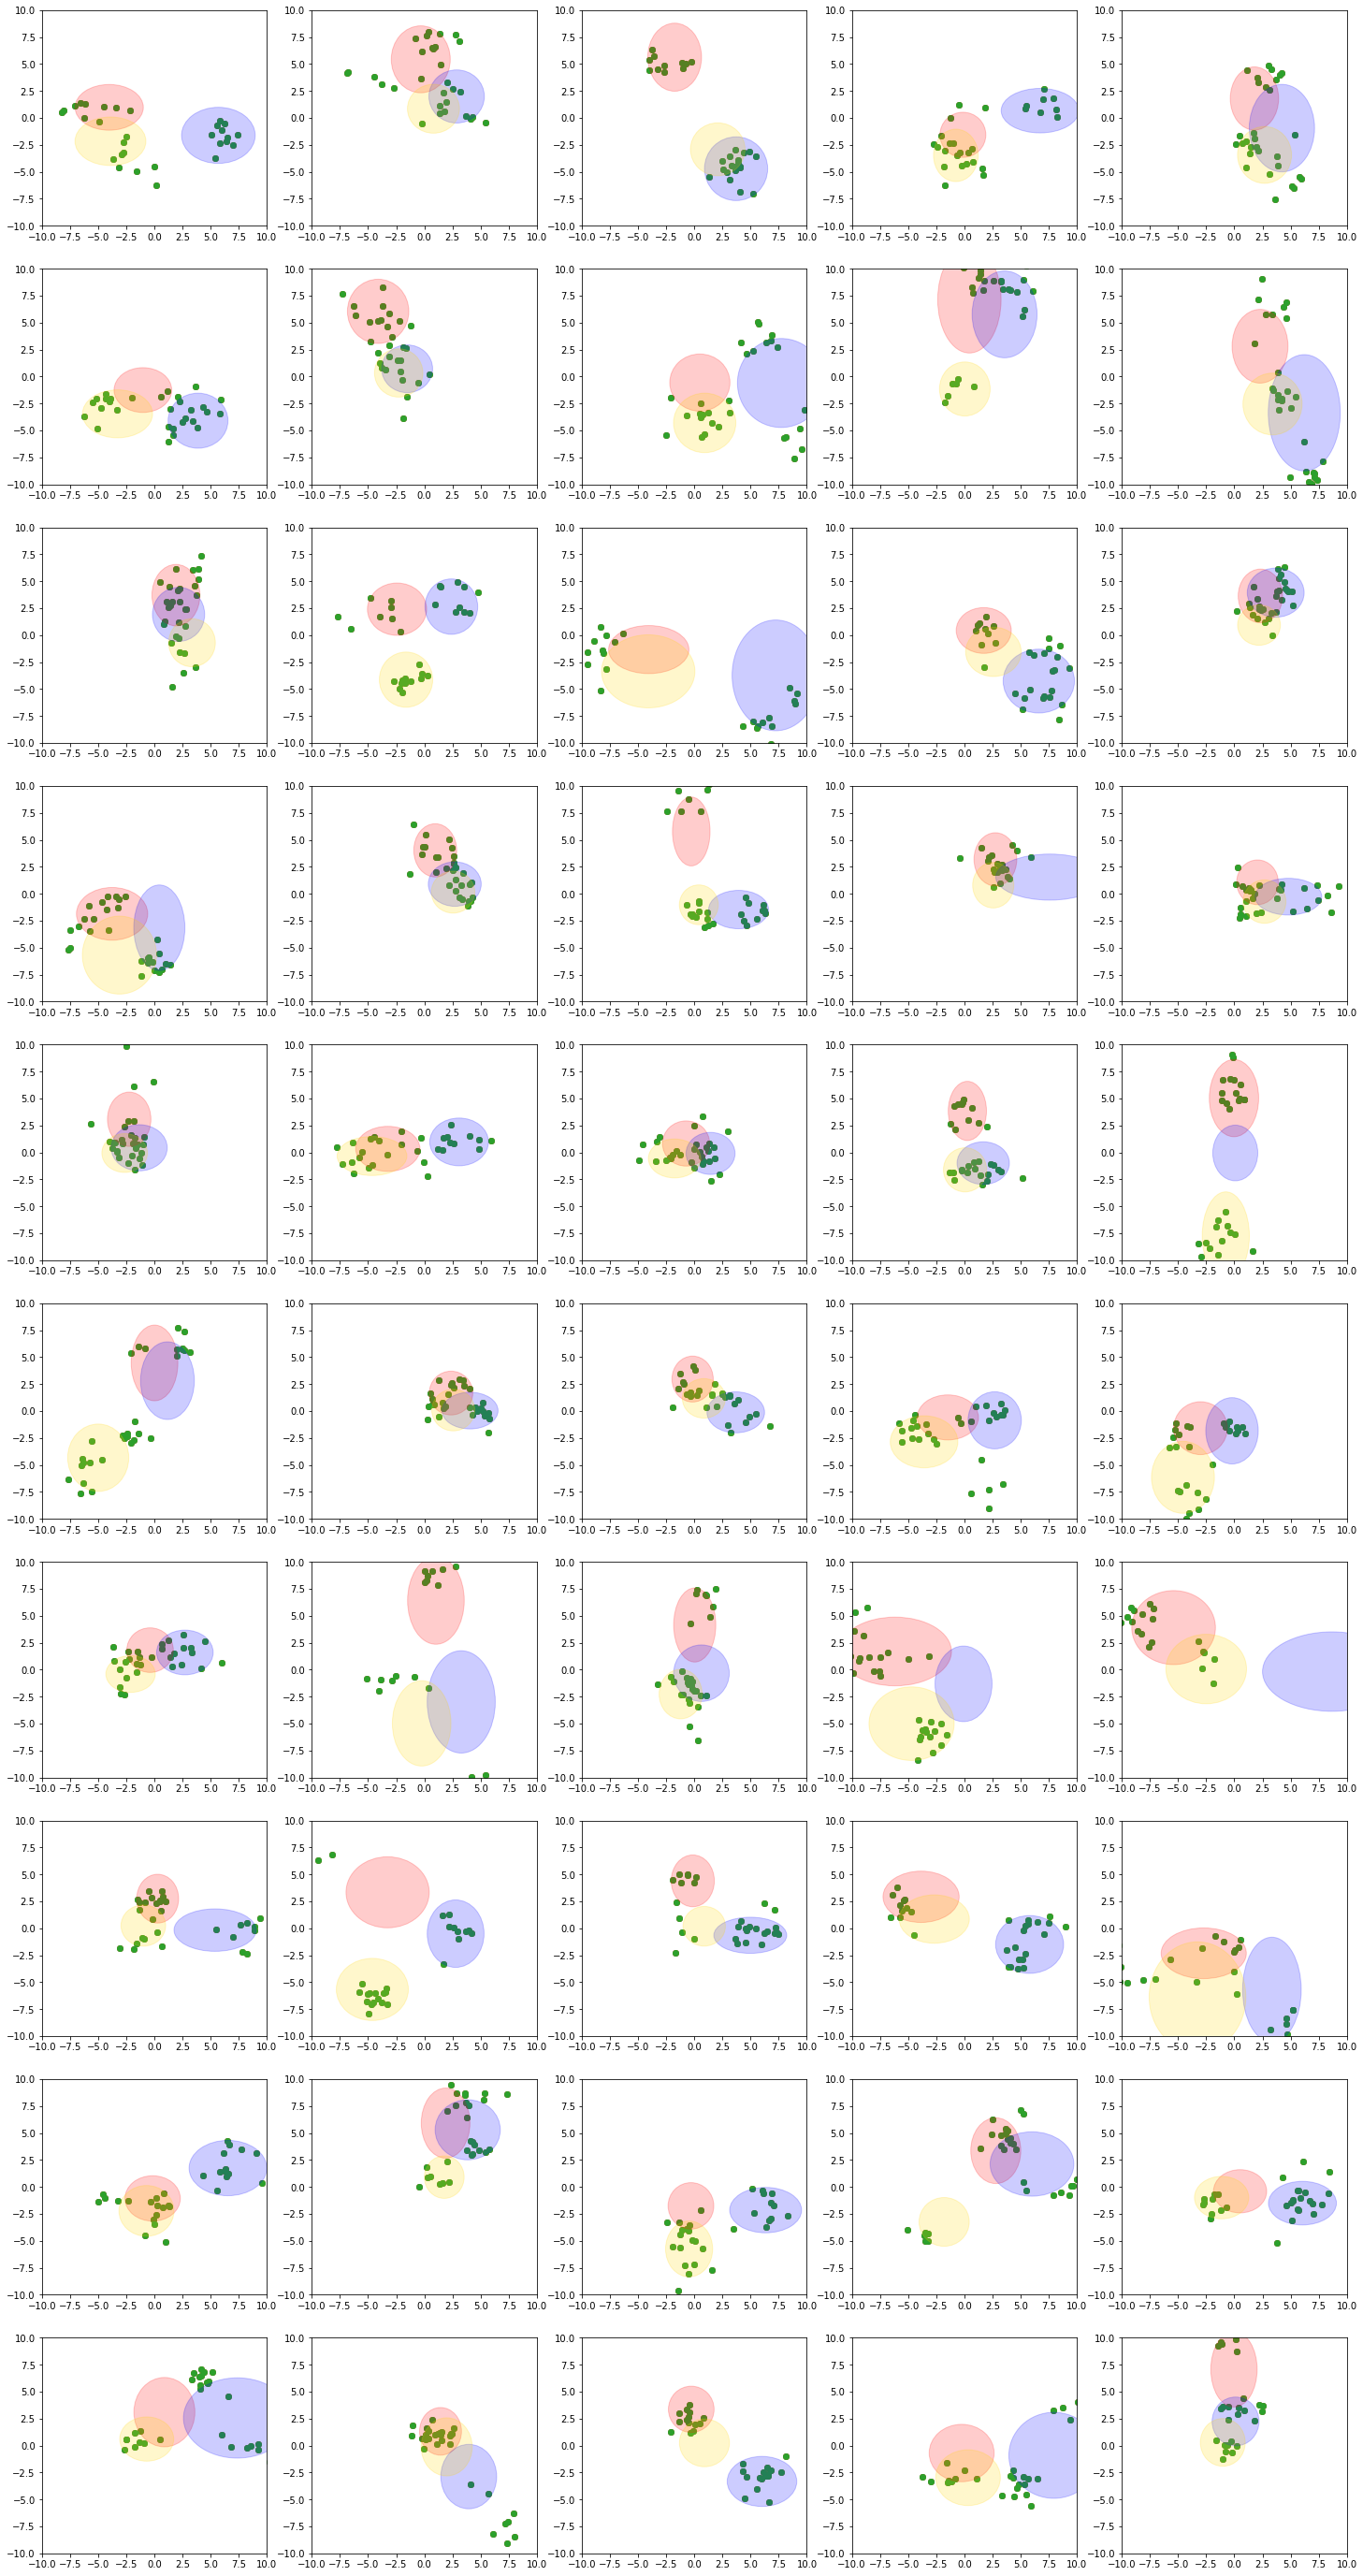

In [24]:
plot_samples(data, q_alpha, q_beta, q_mean, batch_size=50)

In [18]:
q_alpha.shape

torch.Size([1, 50, 6])